<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA_LDA_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial for rELA with LDA preprocessing
### Notes:

### 0.81.x

#### **Implementing *LDA* algorithm in the preprocessing step based on Zhang and Nakaoka (2024, PLOS One).**

The Latent Dirichlet Allocation (LDA) model enables energy landscape analysis (ELA) to be performed in terms of microbiome assemblages, providing a more coarse-grained view of community state transitions.


## Setup

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Cloning into 'rELA'...
remote: Enumerating objects: 1121, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1121 (delta 381), reused 305 (delta 305), pack-reused 703 (from 1)
Receiving objects: 100% (1121/1121), 11.97 MiB | 23.66 MiB/s, done.
Resolving deltas: 100% (556/556), done.


In [ ]:
%%shell
# for topicmodels
sudo apt install gsl-bin libgsl-dbg libgsl-dev libgslcblas0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgsl27
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  gsl-bin libgsl-dbg libgsl-dev libgsl27 libgslcblas0
0 upgraded, 5 newly installed, 0 to remove and 41 not upgraded.
Need to get 5,892 kB of archives.
After this operation, 15.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgslcblas0 amd64 2.7.1+dfsg-3 [94.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl27 amd64 2.7.1+dfsg-3 [1,000 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 gsl-bin amd64 2.7.1+dfsg-3 [11.6 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl-dev amd64 2.7.1+dfsg-3 [1,257 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgsl-dbg amd64 2.7.1+dfsg-3 [3,

In [ ]:
%%R
## package instllation

install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('gsubfn')
install.packages('zoo')
install.packages('gtools')
install.packages('ggsci')
install.packages('igraph')
install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("plot3D")


install.packages("Rcpp")
install.packages('dplyr')
install.packages('tidyr')
install.packages('ggplot2')
install.packages('tidyverse')
install.packages("purrr")
install.packages("devtools")

library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('dplyr')
library('tidyr')
library('ggplot2')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")
library("devtools")

In [ ]:
%%R
# for LDA
install.packages(c("topicmodels", "Matrix", "glmnet", "quanteda"))

In [ ]:
%%R
# for LDA
library("topicmodels")
library("Matrix")
library("stats")
library("quanteda")

In [ ]:
%%R
# If already installed
detach("package:rELA",unload=TRUE)
remove.packages("rELA")

In [ ]:
%%R
install.packages("rELA/rELA.v0.81.tar.gz")
library("rELA")

### Using randomly generated parameter sets

In [ ]:
%%R
# using test data for LDA
randDCmat <- read.csv("rELA/data/abundance_table_LDA.csv", row.names = 1)
vec_idx <- randDCmat[,ncol(randDCmat)]
randDCmat <- randDCmat[,1:ncol(randDCmat)-1]
# Optional
# create dummy data by Dirichlet-Multinominal distribution
# Usage: RandDirichletSet(nspecies, nbasins, nsamples, n_reads=n_reads)

# randDCmat : abndance matrix based on the DM distribution
# prob_vec : probability vector of dirichlet distribution
# vec_idx : indices (indicating category number which each sample belongs to)

# list[randDCmat,prob_vec,vec_idx] <- RandDirichletSet(32, 7, 512, n_reads=10000)

In [ ]:
%%R
# If using test data, species.30 is a rare taxonomy.
head(randDCmat)

         species.1 species.2 species.3 species.4 species.5 species.6 species.7
sample.1       143        20       247       490       215       296       217
sample.2       147        29       232       503       203       290       189
sample.3       144        32       205       492       185       274       194
sample.4       152        21       203       477       201       282       209
sample.5       144        21       208       449       192       270       210
sample.6       163        19       218       491       205       289       194
         species.8 species.9 species.10 species.11 species.12 species.13
sample.1       333        90        823        124        514        292
sample.2       353        79        875        121        565        276
sample.3       333        73        812        104        573        259
sample.4       309        73        837        144        601        267
sample.5       359        81        803        127        559        274
sample.6 

In [ ]:
%%R
# If binarization is done with the threshold 0.01,
# and minimum required occurence is 0.01,
# species.30 is eliminated from the datasets
row_sums <- rowSums(randDCmat)
randDCmat_nom <- sweep(randDCmat, 1, row_sums, "/")
print(colMeans(randDCmat_nom))
list[ocvecs, abvecs, envecs, samplelabel, specieslabel, factorlabel] <- Formatting(randDCmat_nom, NULL, 0, c(0.01, 0.01, 1.01))

   species.1    species.2    species.3    species.4    species.5    species.6 
0.0685097116 0.0183073288 0.0141352087 0.0231625218 0.0382114406 0.0144310949 
   species.7    species.8    species.9   species.10   species.11   species.12 
0.0104505649 0.0644640444 0.0305807944 0.0217924862 0.0135382849 0.0157504214 
  species.13   species.14   species.15   species.16   species.17   species.18 
0.0424161199 0.0084584009 0.0291050459 0.0303459278 0.0244225489 0.0206428475 
  species.19   species.20   species.21   species.22   species.23   species.24 
0.0451804120 0.0508712644 0.0181985683 0.0394019915 0.0542547296 0.0456261022 
  species.25   species.26   species.27   species.28   species.29   species.30 
0.0684962017 0.0229890745 0.0378601532 0.0284579405 0.0257764166 0.0007806175 
  species.31   species.32 
0.0551655646 0.0182161698 
Processed 512 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 1.01 
Selected  31  out of  

### run LDA

In [ ]:
%%R
#'lda_for_ela
#'@description Run LDA using optimal assemblage numbers (K)
#'
#'@param abtable (randDCmat, here) : taxa abundance data (without binarization)
#'@param M: multiplied factors for converting to interger matrix
#'@param K_grid : array of Ks used for searching optimal clusters (K)
#'@param K_fixed: (integer) used for stm.if NULL, optimal K will be searched using K_grid.
#'@param seed : the random seed for clustering.
#'@param train_idx : indices used for training.
#'@param Normalize : (bool) If true, the data will be normalized so that the sum of each row is 1.
#'@returns k_opt : used K for lda
#'@returns theta : sample-assemblage matrix
#'@returns beta : assemblage-taxa matrix)
#'----

list[k_summary,lda_mat,lda_beta] <- lda_for_ela(randDCmat, M=1000, K_grid = 5:10,
                                                 K_fixed = NULL,seed = 2,train_idx = NULL,
                                                 Normalize=TRUE)

[1] "LDA finished."


In [ ]:
%%R
# showing summary for K search
k_summary

   K   logLik perplexity
5  9 -1534022   19.99041
6 10 -1534464   20.00769
4  8 -1536575   20.09034
2  6 -1536826   20.10017
1  5 -1538741   20.17548
3  7 -1538755   20.17601


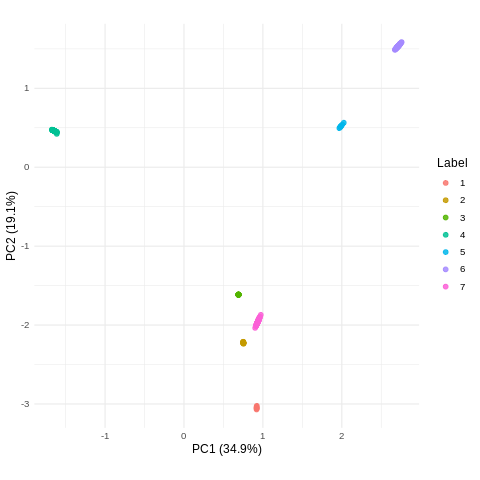

In [ ]:
%%R
# We verify whether samples with similar transformed composition after performing LDA
# on an abundance matrix generated by a Dirichlet multinominal distribution
# share the same label (species distribution) in the original Dirichlet distribution.

# We perform PCA on the matrix after applying LDA and plot the sample composition on two-dimension.
# We then confirm whether the observed clusters in PCA match the labels in the original distribution.

# PCA
p <- prcomp(lda_mat, center = TRUE, scale. = TRUE)
scores <- as.data.frame(p$x[, 1:2])
var_exp <- (p$sdev^2) / sum(p$sdev^2)
scores$label <- factor(vec_idx) # labeling
ggplot(scores, aes(x = PC1, y = PC2, color = label)) + # PC plot
  geom_point(size = 2, alpha = 0.85) +
  coord_equal() +
  labs(
    x = sprintf("PC1 (%.1f%%)", 100 * var_exp[1]),
    y = sprintf("PC2 (%.1f%%)", 100 * var_exp[2]),
    color = "Label"
  ) +
  theme_minimal(base_size = 12)

## run ELA using cluster-based matrix (LDA)


In [ ]:
%%R
head(lda_mat)

                    1          2            3            4          5
sample.1 3.041884e-05 0.02816107 3.041884e-05 3.041884e-05 0.03031474
sample.2 3.047984e-05 0.03245105 3.047984e-05 3.047984e-05 0.03647416
sample.3 3.035808e-05 0.02873233 3.035808e-05 3.035808e-05 0.03526484
sample.4 3.051044e-05 0.03581183 3.051044e-05 3.051044e-05 0.03237183
sample.5 3.044931e-05 0.03842796 3.044931e-05 3.044931e-05 0.03783430
sample.6 3.041884e-05 0.03178991 3.041884e-05 3.041884e-05 0.03152706
                    6         7            8         9
sample.1 3.041884e-05 0.8136926 3.041884e-05 0.1276795
sample.2 3.047984e-05 0.7949163 3.047984e-05 0.1360061
sample.3 3.035808e-05 0.8019176 3.035808e-05 0.1339335
sample.4 3.051044e-05 0.8115145 3.051044e-05 0.1201493
sample.5 3.044931e-05 0.7948946 3.044931e-05 0.1286909
sample.6 3.041884e-05 0.8081392 3.041884e-05 0.1283917


In [ ]:
%%R
# run parameter fitting
list[ocvecs, abvecs, envecs, samplelabel, specieslabel, factorlabel] <- Formatting(lda_mat, NULL, 0, c(0.1, 0.01, 0.99))
list[bp,allresults] <- Findbp(ocvecs,enmat=NULL,rep=32,threads=2,ssize = 0.5,
                              fastfitting = TRUE,intv=100,runadamW=TRUE,sparse=TRUE,
                              lmd = c(5e-05,0.001,0.005,0.01),
                              totalit=3000,maxlr=0.2)


Processed 512 samples.
Relative abundance threshold = 0.1 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
Selected  9  out of  9 species.
Try: lambda=0.000050, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.001000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.005000, we=0.001000, runadamW=TRUE, Sparse=TRUE

Try: lambda=0.010000, we=0.001000, runadamW=TRUE, Sparse=TRUE



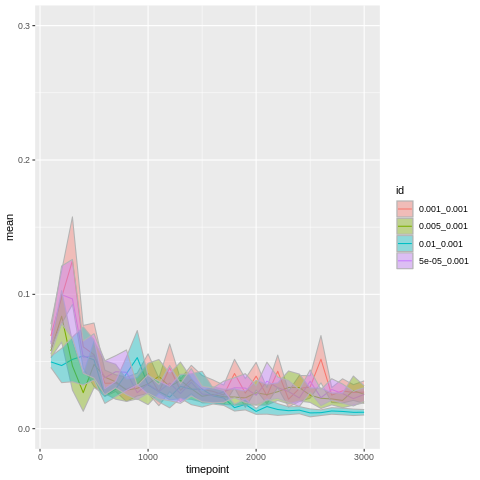

In [ ]:
%%R
plotSAtest(allresults,ylim=c(0,0.3))

In [ ]:
%%R
list[lmd,we,totalit] <- as.numeric(unlist(strsplit(names(bp)[1], split = "_")))
sa <- runSA(ocvecs, enmat=NULL, rep = 64,threads=2,
            getall=FALSE, totalit=totalit,
            lambda = lmd, we = we, maxlr = 0.2)

list[he,je,ge,envecs] <- sa2params(sa)


Start parameter fitting:
SA: elapsed time 76.39 sec



### Running ELA.

In [ ]:
%%R
ela <- ELA(sa, env=NULL,
           SS.itr=20000, FindingTip.itr=10000, # <- the number of steps for finding stable states and tipping points (basically no need to change)
           threads=2, reporting=TRUE)

elap <- ELPruning(ela, th=0.1)

Start ELA:
6 stable states were found.
Checking 15 tipping points.
converting...
ELA: elapsed time 0.96 sec
Start pruning:
*.
ELPruning: elapsed time 0.11 sec


NULL


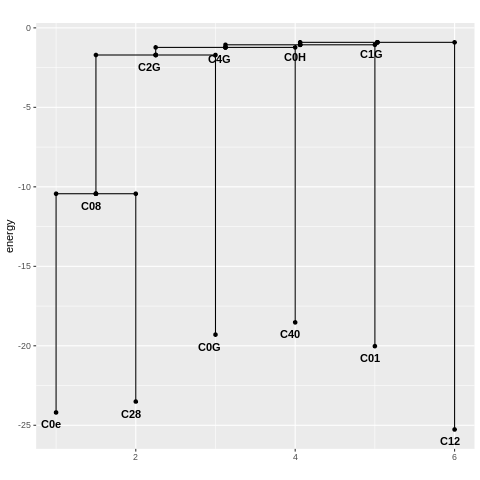

In [ ]:
%%R
# show DG Graph
showDG(ela, lda_mat)

### Extact key species involving transition between 2 stable states from assemlage matrix.

In [ ]:
%%R
# lda_beta: assemblage - species cooccurence matrix
# (Previously, lda_beta matrix is directly used in the calculations, and overall species occurence greatly affected the results.)
# To reduce the overall abundance bias, the lda_beta is noramlized by the average parameters of each species.
p_v <- colSums(lda_beta) / nrow(lda_beta)

# nom_beta: how specific an occurence of each taxa in each assemblage.
nom_beta <- lda_beta / matrix(rep(p_v, each=nrow(lda_beta)), nrow=nrow(lda_beta))

In [ ]:
%%R
head(nom_beta)

    species.1 species.2 species.3 species.4  species.5 species.6 species.7
1 0.010525131 1.8916975 1.9391566 1.6578764 3.78521937 1.3154114 0.5275004
2 1.250498434 0.3987138 0.2729796 1.0352105 0.40443002 0.2790546 2.0068547
3 2.973158963 0.1098633 0.0000000 0.3436556 1.75051290 2.0326659 1.1701295
4 0.008257591 2.2485244 0.3778203 0.6397257 0.10074461 1.1092751 0.1583515
5 0.041597450 0.5184162 3.9290417 0.2286410 0.32310401 0.7635528 3.0433438
6 0.075281386 2.2903116 1.2446775 2.8675907 0.06409622 0.2477340 0.4394566
   species.8 species.9 species.10 species.11 species.12 species.13 species.14
1 0.34927715 1.7538714 0.92325140 5.00568194  0.9040080 0.18144764  0.4095849
2 0.08800349 0.2252321 0.04413342 0.09476504  2.5984913 0.02792995  4.7674920
3 2.10002840 1.2482273 1.29773731 0.09355192  0.2151472 1.52132166  0.1526587
4 0.26759422 2.2129296 0.09963115 0.58630822  0.2274014 1.84405533  0.1264315
5 0.35580120 0.5261222 0.48506469 0.73380063  1.2982800 2.44165725  0.2472074
6 0.024

In [ ]:
%%R
# In this example, species.30 explains compositional changes in the assemblages on the transition from C01 to C0G.
# These scores based on the exclusivity (how specialised a species is to a particular assemblage) rather than the abundace.
nclusters <- 9
target1 <- "01"
target2 <- "0G"
# "C01" -> "C0G"
transition_1 <- t(nom_beta) %*%　id2bin(target1,nclusters) - t(nom_beta) %*%　id2bin(target2,nclusters)
transition_1 <- transition_1[order(transition_1, decreasing = TRUE), ]
transition_1

 species.30  species.32   species.8  species.14  species.20  species.19 
 5.08494309  4.52799565  3.04145195  1.93295249  1.63806646  1.55254815 
 species.21  species.10  species.27  species.25  species.22   species.2 
 1.28678819  0.97613659  0.96909759  0.91747851  0.87734796  0.72809722 
 species.15  species.26  species.16   species.9   species.1   species.4 
 0.41198476  0.37843208  0.34437424  0.08180653  0.04543237 -0.08843999 
 species.17   species.5  species.18  species.11   species.6  species.12 
-0.11767472 -0.18044466 -0.22950517 -0.45499438 -0.59135759 -0.68067575 
 species.31  species.29  species.28  species.23  species.13   species.7 
-0.72633710 -0.76138792 -0.76383640 -1.05610966 -1.64798820 -2.73655063 
  species.3  species.24 
-3.19659933 -4.19762503 


In [ ]:
%%R
# when using lda_beta (without normalization), results drastically changed.
# other case to the above example

transition_2 <- t(lda_beta) %*% id2bin(target1,nclusters) - t(lda_beta) %*% id2bin(target2,nclusters)
transition_2 <- transition_2[order(transition_2, decreasing = TRUE), ]
transition_2

   species.25    species.22    species.27    species.13     species.9 
 1.586346e-01  1.370970e-01  7.707981e-02  7.240504e-02  6.084923e-02 
   species.19     species.2    species.32    species.11    species.21 
 4.632401e-02  3.694713e-02  2.469723e-02  1.352308e-02  1.273274e-02 
    species.6    species.16    species.24    species.18     species.8 
 1.262572e-02  1.185263e-02  1.181910e-02  8.313218e-03  6.755196e-03 
    species.3    species.10    species.31    species.30    species.26 
 2.946896e-03  1.407476e-03  3.260425e-04  8.584989e-05 -6.997889e-03 
    species.5     species.4    species.23     species.7    species.20 
-1.076381e-02 -1.454610e-02 -2.863598e-02 -3.407757e-02 -4.152424e-02 
    species.1    species.28    species.15    species.14    species.17 
-4.550447e-02 -4.564920e-02 -5.224042e-02 -6.306899e-02 -7.147606e-02 
   species.12    species.29 
-8.058131e-02 -2.013560e-01 
